In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd  # Caso esteja lidando com grandes volumes de dados
import linecache
import random
from collections import defaultdict

In [2]:
# Caminho do arquivo do dicionário
caminho_dicionario = "campos_dicionario.txt"

# Tentar carregar com UTF-8 primeiro
try:
    dicionario = pd.read_csv(caminho_dicionario, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    # Se UTF-8 falhar, tentar com Latin-1
    dicionario = pd.read_csv(caminho_dicionario, sep="\t", encoding="latin1")

# Exibir as primeiras linhas
print(dicionario.head())


   Posição Inicial  Tamanho Código da Variável  \
0                1        4                Ano   
1                5        1          Trimestre   
2                6        2                 UF   
3                8        2            Capital   
4               10        2            RM_RIDE   

                                           Descrição  
0                                  Ano de referência  
1                    Trimestre de referência (1 a 4)  
2                               Unidade da Federação  
3                               Município da Capital  
4  Região Metropolitana e Região Administrativa I...  


In [3]:
# Convertendo os valores para números e ajustando a posição inicial para 0-indexed
dicionario["Posição Inicial"] = dicionario["Posição Inicial"].astype(int) - 1
dicionario["Tamanho"] = dicionario["Tamanho"].astype(int)

# Extraindo as larguras das colunas
larguras = dicionario["Tamanho"].tolist()

# Extraindo os nomes das colunas
nomes_colunas = dicionario["Descrição"].tolist()

print("Larguras das colunas:", larguras)
print("Nomes das colunas:", nomes_colunas)


Larguras das colunas: [4, 1, 2, 2, 2, 9, 7, 2, 2, 1, 1, 9, 15, 15, 9, 3, 3, 2, 2, 2, 1, 2, 2, 4, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 4, 1, 1, 5, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 8, 3, 3, 1, 2, 2, 2, 4, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 1, 1, 1, 2, 2, 1, 1]
Nomes das colunas: ['Ano de referência', 'Trimestre de referência (1 a 4)', 'Unidade da Federação', 'Município da Capital', 'Região Metropolitana e Região Administrativa Integrada de Desenvolvimento', 'Unidade Primária de Amostragem (UPA)', 'Grupo de amostra', 'Número de seleção do domicílio', 'Painel (01 a 99)', 'Situação do domicílio', 'Tipo de área (1 - Urbana, 2 - Rural)', 'Projeção da população por níveis geográficos', 'Peso do domicílio e das pessoas', 'Peso do domicílio e das pessoas (c

In [4]:
# Verifica se há colunas duplicadas antes da leitura
from collections import Counter

# Contar a frequência de cada nome
contagem_colunas = Counter(nomes_colunas)

# Exibir colunas duplicadas
colunas_duplicadas = [col for col, count in contagem_colunas.items() if count > 1]

if colunas_duplicadas:
    print("⚠️ Colunas Duplicadas Encontradas:", colunas_duplicadas)
else:
    print("✅ Nenhuma coluna duplicada encontrada.")


⚠️ Colunas Duplicadas Encontradas: ['Valor estimado do rendimento em produtos (em reais)']


In [5]:
# Resolver duplicatas adicionando um sufixo único
nomes_corrigidos = []
contador = {}

for col in nomes_colunas:
    if col in contador:
        contador[col] += 1
        nomes_corrigidos.append(f"{col}_{contador[col]}")
    else:
        contador[col] = 1
        nomes_corrigidos.append(col)

# Atualizar a lista de nomes com os novos nomes únicos
nomes_colunas = nomes_corrigidos


In [6]:
# Caminho do arquivo de microdados
caminho_microdados = "raw/PNADC_2023_visita1_20241220/PNADC_2023_visita1.txt"
dicionario_path = "campos_dicionario.txt"

# Carregar o dicionário
dicionario = pd.read_csv(dicionario_path, sep="\t")

# Extrair nomes e larguras das colunas
nomes_colunas_corrigidos = dicionario["Descrição"].tolist()
larguras = dicionario["Tamanho"].tolist()

In [7]:
# Verifica e corrige nomes duplicados automaticamente
contador = Counter(nomes_colunas_corrigidos)
nomes_colunas_unicos = []
ocorrencias = {}

for nome in nomes_colunas_corrigidos:
    if contador[nome] == 1:
        nomes_colunas_unicos.append(nome)
    else:
        ocorrencias[nome] = ocorrencias.get(nome, 0) + 1
        novo_nome = f"{nome}_{ocorrencias[nome]}"
        nomes_colunas_unicos.append(novo_nome)

# Substitui os nomes antigos pelos únicos
nomes_colunas_corrigidos = nomes_colunas_unicos

In [8]:
# Parâmetros
caminho_microdados = "raw/PNADC_2023_visita1_20241220/PNADC_2023_visita1.txt"
amostra_n = 100000
pos_uf = (5, 7)  # Coluna UF está entre posições 5-6 (índice Python exclui o último)

# === 1. IDENTIFICAR A DISTRIBUIÇÃO DA COLUNA UF COM LEITURA POR LINHAS ===
contagem_ufs = defaultdict(list)
total_linhas = 0

with open(caminho_microdados, "r", encoding="latin1") as f:
    for i, linha in enumerate(f):
        uf = linha[pos_uf[0]:pos_uf[1]]
        contagem_ufs[uf].append(i + 1)  # +1 porque linecache usa 1-based
        total_linhas += 1

print("✅ Total de linhas:", total_linhas)
print("📊 UF encontradas:", {k: len(v) for k, v in contagem_ufs.items()})

# === 2. FAZER AMOSTRAGEM ESTRATIFICADA COM BASE NA DISTRIBUIÇÃO ===
amostragem = []
ufs = list(contagem_ufs.keys())
amostras_por_uf = amostra_n // len(ufs)

for uf in ufs:
    linhas_uf = contagem_ufs[uf]
    selecionadas = random.sample(linhas_uf, min(len(linhas_uf), amostras_por_uf))
    amostragem.extend(selecionadas)

print(f"🎯 Total de linhas amostradas: {len(amostragem)}")

# === 3. PEGAR LINHAS COM LINECACHE E SALVAR TEMPORÁRIO ===
linhas_texto = [linecache.getline(caminho_microdados, i) for i in amostragem]

with open("amostra_temp.txt", "w", encoding="latin1") as f:
    f.writelines(linhas_texto)

# === 4. LER A AMOSTRA FINAL ===
df_amostra = pd.read_fwf(
    "amostra_temp.txt",
    widths=larguras,
    names=nomes_colunas_corrigidos,
    encoding="latin1"
)

# 🎉 Pronto!

✅ Total de linhas: 383049
📊 UF encontradas: {'11': 6149, '12': 7607, '13': 11170, '14': 4650, '15': 14292, '16': 3174, '17': 6000, '21': 24943, '22': 8893, '23': 18149, '24': 7662, '25': 10196, '26': 15967, '27': 15753, '28': 7353, '29': 19022, '31': 28447, '32': 13456, '33': 26932, '35': 30245, '41': 20640, '42': 23851, '43': 20462, '50': 8425, '51': 10018, '52': 12611, '53': 6982}
🎯 Total de linhas amostradas: 99452


In [9]:
df_amostra.rename(columns={"Unidade da Federação": "UF"}, inplace=True)


In [10]:
[print(df_amostra['UF'].value_counts())
]

UF
11    3703
12    3703
13    3703
14    3703
15    3703
17    3703
21    3703
23    3703
22    3703
24    3703
25    3703
35    3703
26    3703
27    3703
28    3703
29    3703
31    3703
32    3703
33    3703
50    3703
41    3703
42    3703
43    3703
52    3703
51    3703
53    3703
16    3174
Name: count, dtype: int64


[None]

In [11]:
# Verificar o shape
print(f"✅ Shape do DataFrame: {df_amostra.shape}")

# Verificar valores nulos por coluna (parcial)
print("\n🔍 Valores nulos por coluna (top 10):")
print(df_amostra.isnull().sum().sort_values(ascending=False).head(10))

# Verificar tipos de dados
print("\n📌 Tipos de dados:")
print(df_amostra.dtypes.value_counts())


✅ Shape do DataFrame: (99452, 159)

🔍 Valores nulos por coluna (top 10):
Recebeu outros programas sociais do governo?                     99452
Recebeu pensão alimentícia, doação ou mesada?                    99452
Conseguiu um novo trabalho?                                      99451
Gostaria de ter trabalhado na semana de referência?              99451
Motivo de não ter tomado providência para conseguir trabalho     99451
Em quantos meses começará o novo trabalho?                       99451
Está sem trabalho e tentando conseguir há quanto tempo?          99451
Faixa do rendimento recebido em produtos no mês de referência    99451
No mês de referência, estaria disponível para trabalhar mais?    99451
Tomou alguma providência para conseguir trabalho?                99451
dtype: int64

📌 Tipos de dados:
float64    127
int64       23
object       9
Name: count, dtype: int64


In [12]:
colunas_totalmente_nulas = df_amostra.columns[df_amostra.isnull().all()]
print("🔴 Colunas com 100% de nulos:", list(colunas_totalmente_nulas))


🔴 Colunas com 100% de nulos: ['Recebeu outros programas sociais do governo?', 'Recebeu pensão alimentícia, doação ou mesada?']


In [13]:
# Remover colunas com 100% de valores nulos
colunas_100_nulos = ['Recebeu outros programas sociais do governo?', 
                     'Recebeu pensão alimentícia, doação ou mesada?']

df_amostra.drop(columns=colunas_100_nulos, inplace=True)
print("✅ Colunas removidas com sucesso!")


✅ Colunas removidas com sucesso!


In [14]:
# Selecionar colunas float64 sem nulos
colunas_float_sem_nulos = df_amostra.select_dtypes(include='float64').columns[df_amostra.select_dtypes(include='float64').isnull().sum() == 0]

# Converter para int
for col in colunas_float_sem_nulos:
    df_amostra[col] = df_amostra[col].astype(int)

print(f"✅ Colunas convertidas para int: {list(colunas_float_sem_nulos)}")


✅ Colunas convertidas para int: ['Peso do domicílio e das pessoas', 'Peso do domicílio e das pessoas (com correção)']


In [15]:
print([col for col in df_amostra.columns if "Sexo" in col])


['Sexo (1 - Masculino, 2 - Feminino)']


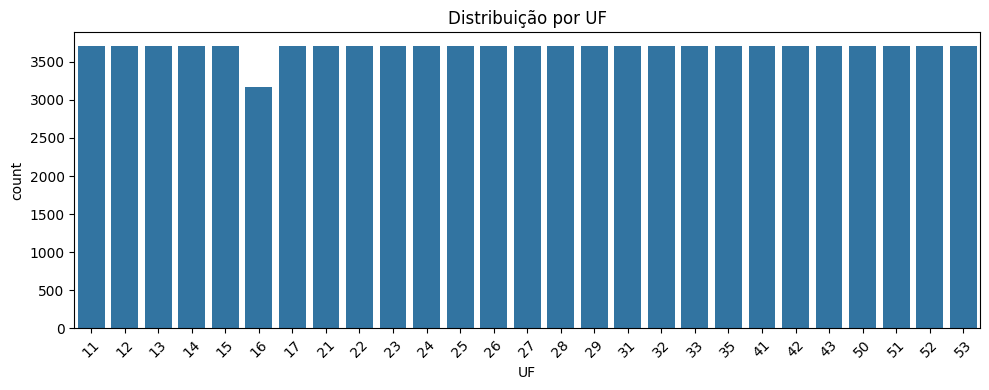

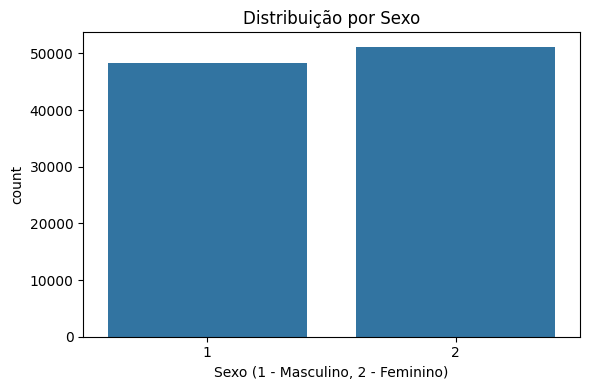

In [16]:
# Plot distribuição de Unidade da Federação
plt.figure(figsize=(10, 4))
sns.countplot(data=df_amostra, x="UF")
plt.title("Distribuição por UF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribuição de Sexo
plt.figure(figsize=(6, 4))
sns.countplot(data=df_amostra, x="Sexo (1 - Masculino, 2 - Feminino)")
plt.title("Distribuição por Sexo")
plt.tight_layout()
plt.show()

In [17]:
# 🧠 Dicionários de mapeamento
mapeamentos = {
    "Sexo": {1: "Masculino", 2: "Feminino"},
    "V2010": {1: "Branca", 2: "Preta", 3: "Amarela", 4: "Parda", 5: "Indígena", 9: "Ignorado"},
    "V3001": {1: "Sim", 2: "Não"},
    "V3002": {1: "Sim", 2: "Não"},
    "V1023": {1: "Urbana", 2: "Rural"},
    "V4001": {1: "Sim", 2: "Não"},
    "V4033": {1: "Sim", 2: "Não"},
    "V40332": {1: "Sim", 2: "Não"},
    "V4034": {1: "Sim", 2: "Não"},
    "S01001": {1: "Casa", 2: "Apartamento", 3: "Cômodo", 4: "Outro"},
    "S01002": {1: "Alvenaria", 2: "Madeira", 3: "Taipa", 4: "Outro"},
}

# 🧹 Aplicar mapeamento às colunas
for coluna, dicionario in mapeamentos.items():
    if coluna in df_amostra.columns:
        df_amostra[coluna] = df_amostra[coluna].map(dicionario)

print("✅ Variáveis categóricas mapeadas com sucesso!")


✅ Variáveis categóricas mapeadas com sucesso!


In [18]:
# Exibir primeiras linhas para conferir
print(df_amostra.head())

   Ano de referência  Trimestre de referência (1 a 4)  UF  \
0               2023                                2  11   
1               2023                                4  11   
2               2023                                1  11   
3               2023                                4  11   
4               2023                                3  11   

   Município da Capital  \
0                   NaN   
1                   NaN   
2                  11.0   
3                   NaN   
4                   NaN   

   Região Metropolitana e Região Administrativa Integrada de Desenvolvimento  \
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                                NaN                           
4                                                NaN                  

In [19]:
# 🧹 Remover colunas 100% nulas
df = df_amostra.dropna(axis=1, how='all')

# 🧠 Renomear colunas importantes
df.rename(columns={
    'Ano de referência': 'Ano',
    'Trimestre de referência (1 a 4)': 'Trimestre',
    'Unidade da Federação': 'UF',
    'Município da Capital': 'Capital',
    'Região Metropolitana e Região Administrativa Integrada de Desenvolvimento': 'RM_RIDE',
    'Unidade Primária de Amostragem (UPA)': 'UPA',
    'Grupo de amostra': 'Estrato',
    'Número de seleção do domicílio': 'Selecao_Domicilio',
    'Painel (01 a 99)': 'Painel',
    'Situação do domicílio': 'Situacao_Domicilio',
    'Tipo do domicílio (1 - Casa, 2 - Apartamento, etc.)': 'Tipo_Domicilio',
    'Material predominante das paredes externas': 'Material_Paredes',
    'Material predominante do telhado': 'Material_Telhado',
    'Material predominante do piso': 'Material_Piso',
    'Quantidade de cômodos': 'Comodos',
    'Quantidade de dormitórios': 'Dormitorios',
    'Principal forma de abastecimento de água': 'Abastecimento_Agua',
    'O domicílio tem acesso à rede geral de distribuição de água?': 'Acesso_Rede_Agua',
    'Sexo (1 - Masculino, 2 - Feminino)': 'Sexo',
    'Cor ou raça': 'Cor_Raca'
}, inplace=True)

# 🔄 Mapeamentos das variáveis categóricas

df['Tipo_Domicilio'] = df['Tipo_Domicilio'].map({
    1: 'Casa', 2: 'Apartamento', 3: 'Cômodo', 4: 'Outro'
})

df['Material_Paredes'] = df['Material_Paredes'].map({
    1: 'Alvenaria', 2: 'Madeira', 3: 'Taipa', 4: 'Outro'
})

df['Material_Telhado'] = df['Material_Telhado'].map({
    1: 'Telha', 2: 'Laje', 3: 'Palha', 4: 'Outro'
})

df['Material_Piso'] = df['Material_Piso'].map({
    1: 'Cerâmica', 2: 'Cimento', 3: 'Madeira', 4: 'Terra'
})

df['Abastecimento_Agua'] = df['Abastecimento_Agua'].map({
    1: 'Rede Geral', 2: 'Poço', 3: 'Caminhão-pipa', 4: 'Outro'
})

df['Acesso_Rede_Agua'] = df['Acesso_Rede_Agua'].map({
    1: 'Sim', 2: 'Não'
})

# 🧽 Converter floats que são inteiros
for col in df.select_dtypes(include='float64').columns:
    if df[col].dropna().apply(float.is_integer).all():
        df[col] = df[col].astype('Int64')  # Int64 permite valores nulos

# ✅ Visualizar estrutura após limpeza
print("🔍 DataFrame final:")
print(df.info())


🔍 DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99452 entries, 0 to 99451
Columns: 157 entries, Ano to Acesso_Rede_Agua
dtypes: Int64(118), int64(24), object(15)
memory usage: 130.3+ MB
None


In [20]:
# Dicionários de mapeamento
map_uf = {
    11: 'Rondônia',
    12: 'Acre',
    13: 'Amazonas',
    14: 'Roraima',
    15: 'Pará',
    16: 'Amapá',
    17: 'Tocantins',
    21: 'Maranhão',
    22: 'Piauí',
    23: 'Ceará',
    24: 'Rio Grande do Norte',
    25: 'Paraíba',
    26: 'Pernambuco',
    27: 'Alagoas',
    28: 'Sergipe',
    29: 'Bahia',
    31: 'Minas Gerais',
    32: 'Espírito Santo',
    33: 'Rio de Janeiro',
    35: 'São Paulo',
    41: 'Paraná',
    42: 'Santa Catarina',
    43: 'Rio Grande do Sul',
    50: 'Mato Grosso do Sul',
    51: 'Mato Grosso',
    52: 'Goiás',
    53: 'Distrito Federal'
}

map_sexo = {1: 'Masculino', 2: 'Feminino'}

map_cor = {
    1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indígena',
    9: 'Sem declaração'
}

map_tipo_domicilio = {1: 'Casa', 2: 'Apartamento', 3: 'Cômodo', 4: 'Outros'}

map_material_paredes = {
    1: 'Alvenaria com revestimento', 2: 'Alvenaria sem revestimento',
    3: 'Taipa com revestimento', 4: 'Taipa sem revestimento',
    5: 'Madeira aparelhada', 6: 'Madeira reaproveitada',
    7: 'Palha, etc.', 8: 'Outro material'
}

# Aplique os mapeamentos
df['UF'] = df['UF'].map(map_uf)
df['Sexo'] = df['Sexo'].map(map_sexo)
df['Cor_Raca'] = df['Cor_Raca'].map(map_cor)
df['Tipo_Domicilio'] = df['Tipo_Domicilio'].map(map_tipo_domicilio)
df['Material_Paredes'] = df['Material_Paredes'].map(map_material_paredes)

# Exibe para conferência
print(df[['UF', 'Sexo', 'Cor_Raca', 'Tipo_Domicilio', 'Material_Paredes']].head())

         UF       Sexo Cor_Raca Tipo_Domicilio Material_Paredes
0  Rondônia   Feminino   Branca            NaN              NaN
1  Rondônia  Masculino    Parda            NaN              NaN
2  Rondônia  Masculino    Parda            NaN              NaN
3  Rondônia   Feminino   Branca            NaN              NaN
4  Rondônia   Feminino    Parda            NaN              NaN


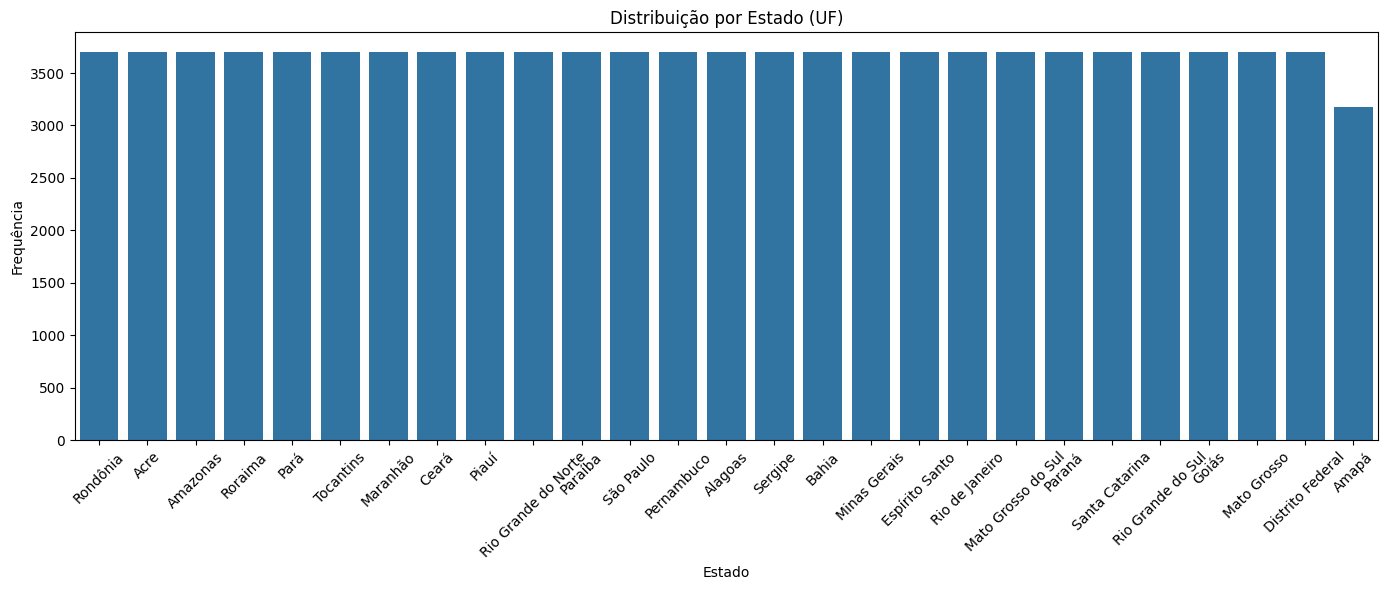

In [21]:
plt.figure(figsize=(14, 6))
sns.countplot(x='UF', data=df, order=df['UF'].value_counts().index)
plt.title('Distribuição por Estado (UF)')
plt.xlabel('Estado')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

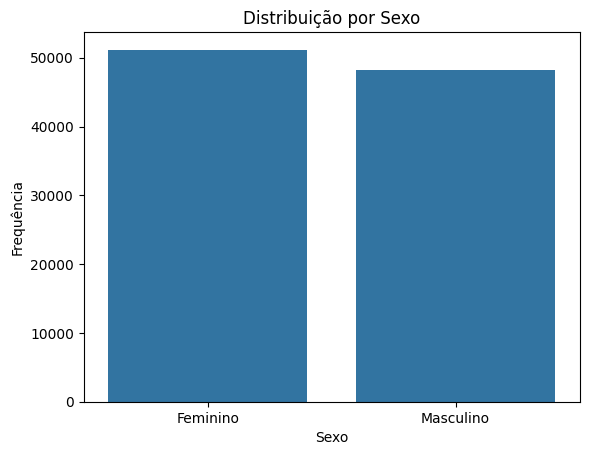

In [22]:
sns.countplot(x='Sexo', data=df)
plt.title('Distribuição por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Frequência')
plt.show()


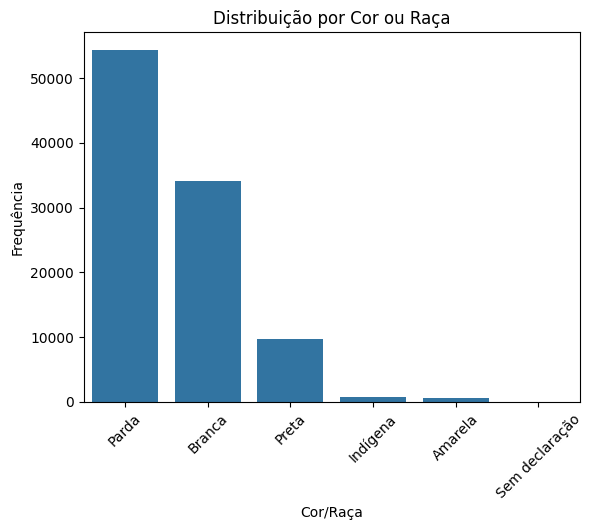

In [23]:
sns.countplot(x='Cor_Raca', data=df, order=df['Cor_Raca'].value_counts().index)
plt.title('Distribuição por Cor ou Raça')
plt.xlabel('Cor/Raça')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()


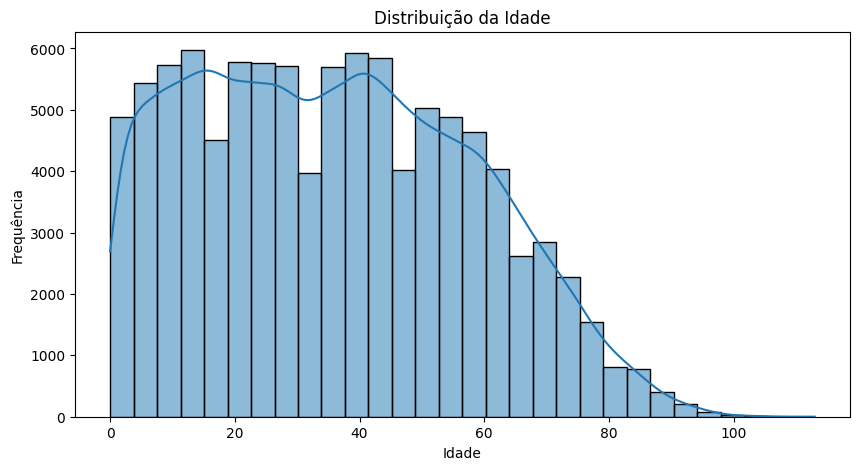

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Idade do morador na data de referência'], bins=30, kde=True)
plt.title('Distribuição da Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()


count       3559.0
mean      8.610846
std      14.379073
min            0.0
25%            0.0
50%            0.0
75%           20.0
max           95.0
Name: Valor exato do rendimento mensal (em reais), dtype: Float64


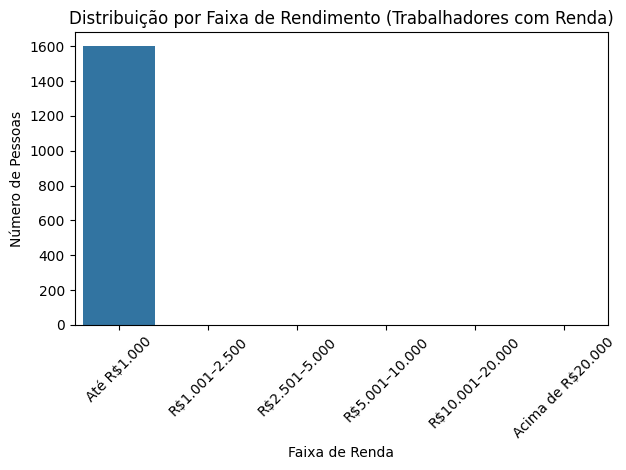

In [25]:
# Filtrar quem trabalhou E recebeu rendimento em dinheiro
df_renda_valida = df[
    (df['Trabalhou na semana de referência? (1 - Sim, 2 - Não)'] == 1) &
    (df['Recebeu rendimento em dinheiro no mês de referência? (1 - Sim, 2 - Não)'] == 1)
]

# Visualizar estatísticas
print(df_renda_valida['Valor exato do rendimento mensal (em reais)'].describe())

# 📊 Plotar distribuição com faixas

bins = [0, 1000, 2500, 5000, 10000, 20000, df['Valor exato do rendimento mensal (em reais)'].max()]
labels = ['Até R$1.000', 'R$1.001–2.500', 'R$2.501–5.000', 'R$5.001–10.000', 'R$10.001–20.000', 'Acima de R$20.000']

df_renda_valida = df_renda_valida.copy()
df_renda_valida['Faixa_Renda'] = pd.cut(df_renda_valida['Valor exato do rendimento mensal (em reais)'], bins=bins, labels=labels)


sns.countplot(x='Faixa_Renda', data=df_renda_valida)
plt.title('Distribuição por Faixa de Rendimento (Trabalhadores com Renda)')
plt.xlabel('Faixa de Renda')
plt.ylabel('Número de Pessoas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
print(df_renda_valida['Valor exato do rendimento mensal (em reais)'].value_counts().head(10))


Valor exato do rendimento mensal (em reais)
0     1959
20     949
2      403
50      85
12      42
80      24
30      13
70       6
25       6
22       5
Name: count, dtype: Int64


In [27]:
# Filtrar apenas as pessoas que trabalharam na semana de referência
df_trabalhadores = df[df["Trabalhou na semana de referência? (1 - Sim, 2 - Não)"] == 1]



In [28]:
# Filtrar pessoas com 'renda exata = 0'
renda_zero = df_trabalhadores[df_trabalhadores['Valor exato do rendimento mensal (em reais)'] == 0]

# Ver quantas delas disseram que receberam produtos
produtos = renda_zero['Recebeu produtos ou mercadorias como pagamento? (1 - Sim, 2 - Não)'].value_counts()

# Ver quantas receberam benefícios
beneficios = renda_zero['Recebeu benefícios como pagamento? (1 - Sim, 2 - Não)'].value_counts()

# Ver quantas têm dados no trabalho secundário
secundario = renda_zero['Recebia rendimento no trabalho secundário? (1 - Sim, 2 - Não)'].value_counts()

print("📦 Produtos:\n", produtos)
print("\n🎁 Benefícios:\n", beneficios)
print("\n🛠️ Trabalho Secundário:\n", secundario)


📦 Produtos:
 Recebeu produtos ou mercadorias como pagamento? (1 - Sim, 2 - Não)
2    23
1     6
Name: count, dtype: Int64

🎁 Benefícios:
 Recebeu benefícios como pagamento? (1 - Sim, 2 - Não)
0    5796
Name: count, dtype: Int64

🛠️ Trabalho Secundário:
 Recebia rendimento no trabalho secundário? (1 - Sim, 2 - Não)
0    175
6     71
1     60
2     37
3     27
4     17
5     16
7     14
8     12
9      5
Name: count, dtype: Int64


In [29]:
# Lista das colunas de renda
colunas_renda = [
    'Valor exato do rendimento mensal (em reais)',
    'Valor estimado do rendimento em produtos (em reais)_1',
    'Valor recebido de aposentadoria ou pensão (em reais)',
    'Valor recebido do seguro-desemprego (em reais)',
    'Valor exato do rendimento no trabalho secundário (em reais)',
    'Valor estimado do rendimento em produtos (em reais)_2',
    'Valor recebido de outros rendimentos (em reais)'
]

# Filtrar colunas que realmente existem no DataFrame
colunas_renda_validas = [col for col in colunas_renda if col in df.columns]

# Garantir que todas estejam em formato numérico
for col in colunas_renda_validas:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Criar a coluna Renda_Total somando tudo (com NaNs tratados como 0)
df['Renda_Total'] = df[colunas_renda_validas].fillna(0).sum(axis=1)

# Verificar a distribuição
print(df['Renda_Total'].describe())


count           99452.0
mean      114725.584634
std      1768176.761278
min                 0.0
25%                 0.0
50%                 0.0
75%                 0.0
max          94438222.0
Name: Renda_Total, dtype: Float64


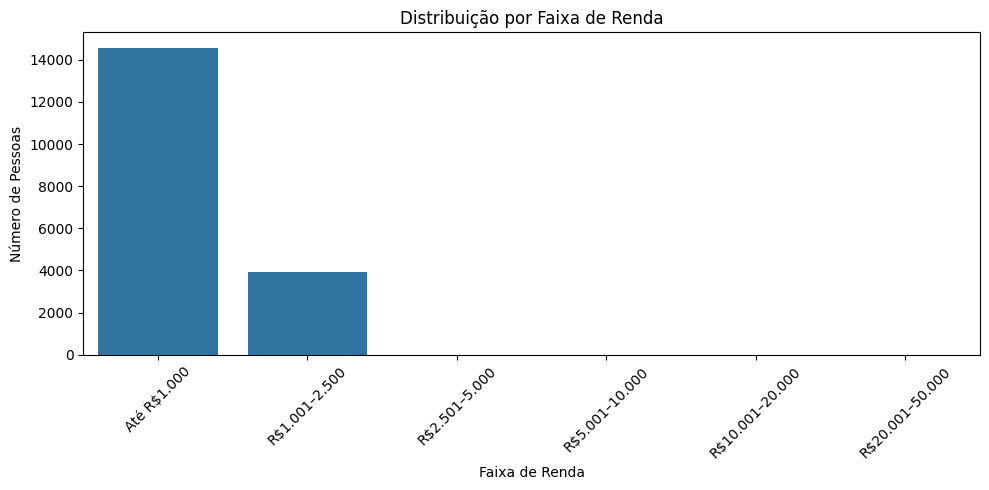

In [30]:

# Filtrar apenas valores positivos e abaixo de um teto razoável (ex: 50 mil)
df_renda_plot = df[(df['Renda_Total'] > 0) & (df['Renda_Total'] < 50000)]

# Criar faixas personalizadas
bins = [0, 1000, 2500, 5000, 10000, 20000, 50000]
labels = [
    'Até R$1.000', 'R$1.001–2.500', 'R$2.501–5.000',
    'R$5.001–10.000', 'R$10.001–20.000', 'R$20.001–50.000'
]

# Criar coluna categórica de faixas
df_renda_plot = df_renda_plot.copy()
df_renda_plot['Faixa_Renda'] = pd.cut(df_renda_plot['Renda_Total'], bins=bins, labels=labels)

# Plotar
plt.figure(figsize=(10, 5))
sns.countplot(x='Faixa_Renda', data=df_renda_plot, order=labels)
plt.title('Distribuição por Faixa de Renda')
plt.xlabel('Faixa de Renda')
plt.ylabel('Número de Pessoas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Salvar DataFrame limpo e tratado
df.to_csv("dados_limpos_exploracao.csv", index=False, encoding='utf-8-sig')

print("✅ Arquivo salvo com sucesso como 'dados_limpos_exploracao.csv'")


✅ Arquivo salvo com sucesso como 'dados_limpos_exploracao.csv'
